In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

2023-08-21 12:44:01.550304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
# Load embeddings data
training_embeddings = np.load('projected_train_embs.npy')
print("Embeddings shape", training_embeddings.shape)
training_embeddings[3:]

Embeddings shape (12130, 32)


array([[ 0.34154157, -0.25009701,  0.41873148, ...,  0.1295138 ,
        -0.12382773,  0.02611334],
       [-0.46295469, -0.20625862, -0.01951506, ...,  0.05471029,
         0.15638472,  0.05254342],
       [ 0.20490593,  0.19485151,  0.14043505, ..., -0.14812004,
         0.00460242, -0.08775376],
       ...,
       [ 0.38076696,  0.44038801, -0.40614511, ..., -0.02166328,
         0.07803639, -0.19557152],
       [ 0.19642034, -0.20449911,  0.64830647, ...,  0.11545152,
        -0.04743452, -0.09632246],
       [ 0.23217733,  0.14049537,  0.4784929 , ...,  0.17514701,
         0.11465517,  0.08526579]])

In [3]:
# Load cosine similarity data
cosine_similarity_matrix = np.load('og_train_cos_theta.npy')
print("Cosine similarity shape", cosine_similarity_matrix.shape)
cosine_similarity_matrix[3:]

Cosine similarity shape (12130, 12130)


array([[0.83787816, 0.83438727, 0.79985844, ..., 0.79386096, 0.85675628,
        0.79112826],
       [0.79880921, 0.83342499, 0.87225286, ..., 0.78417471, 0.81157338,
        0.77252879],
       [0.79382085, 0.82562821, 0.78502709, ..., 0.79344783, 0.79214703,
        0.79230007],
       ...,
       [0.79577725, 0.79087241, 0.81281707, ..., 0.99999996, 0.76811411,
        0.75941686],
       [0.823834  , 0.82349527, 0.7803674 , ..., 0.76811411, 0.99999996,
        0.80423958],
       [0.78055384, 0.7598553 , 0.74479524, ..., 0.75941686, 0.80423958,
        1.00000001]])

# Training v1

#### High level approach:
- Autoencoder seems a nice baseline to get started 
- The idea behind using an autoencoder is to leverage the lower-dimensional embeddings (training_embeddings) to learn a representation that can at least approximate, the higher-dimensional embeddings. 
- The provided cosine similarity matrix (cosine_similarity_matrix) serves as a guide to ensure the relationships between vectors are preserved.
- To achieve this, lets define an autoencoder with the encoder reducing the embeddings to 32 dimensions and the decoder expanding them to a higher dimension (1536).
- Train the autoencoder using the lower-dimensional embeddings (training_embeddings) as input and a dummy target variable.
- Oserve the loss to make sure no underfitting
- Compare the calculated cosine similarity matrix from the prediction of autoencoder to the original one
- Calculate the average difference. This can be used for further optimization

In [4]:
# Plot the training and validation loss
def plot_training_val_loss(model_history):
    plt.figure(figsize=(10, 6))
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [5]:
# Build the model
input_dim = 32
output_dim = 1536
learning_rate=0.001
patience=5
min_delta = 0.001

#### The key assumption here is that by minimizing the mean squared error during training, the autoencoder will learn a transformation that preserves the relationships and angles between vectors as much as possible. The approach is based on the idea that similar vectors in the original 32-dimensional space should remain similar after upsampling to the 1536-dimensional space.

#### Lets introduce a dummy target assuming the original high-dimensional embeddings represented by dummy_target here to guide the training

In [6]:
def build_autoencoder(input_dim, encoded_dim, output_dim, dropout_rate=0.1, l2_reg=1e-4):
    # Encoder
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    encoded = Dense(encoded_dim, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    
    # Decoder
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(encoded)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='linear', kernel_regularizer=l2(l2_reg))(x)
    
    autoencoder = Model(inputs=inputs, outputs=outputs)
    return autoencoder

In [7]:
# Let's use Mean Squared Error as the loss function and the Adam optimizer
autoencoder = build_autoencoder(32, 32, 1536)
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

In [8]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 512)               16896     
                                                             

In [9]:
# Dummy target
dummy_target = np.random.rand(12130, 1536)

In [10]:
# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=patience, min_delta = min_delta, restore_best_weights=True)

In [11]:
# Training the autoencoder
history_ae = autoencoder.fit(
    training_embeddings, 
    dummy_target, 
    epochs=100, 
    batch_size=256, 
    validation_split=0.1,
    callbacks=[early_stopping])

Epoch 1/100
43/43 [==============================] - 2s 23ms/step - loss: 0.4664 - val_loss: 0.2391
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1873 - val_loss: 0.1355
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1434 - val_loss: 0.1197
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1252 - val_loss: 0.1105
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1146 - val_loss: 0.1046
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1077 - val_loss: 0.1008
Epoch 7/100
43/43 [==============================] - 1s 22ms/step - loss: 0.1033 - val_loss: 0.0981
Epoch 8/100
43/43 [==============================] - 1s 23ms/step - loss: 0.1003 - val_loss: 0.0962
Epoch 9/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0982 - val_loss: 0.0946
Epoch 10/100
43/43 [==============================] - 1s 24ms/step - loss: 0.0962 - val_loss: 0.0933

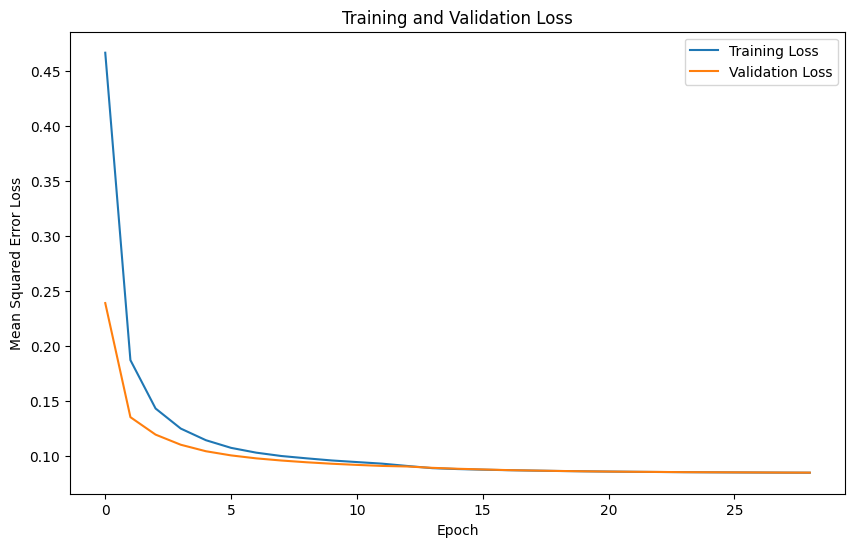

In [12]:
plot_training_val_loss(history_ae)

### Save model

In [13]:
autoencoder.save('autoencoder_v1.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Load model weights and predict

In [14]:
# Load your autoencoder and weights
autoencoder = load_model('autoencoder_v1.h5')

In [15]:
# Predict higher-dimensional embeddings from lower-dimensional input
lower_dimension_embeddings = training_embeddings
higher_dimension_embeddings = autoencoder.predict(lower_dimension_embeddings)
print(f'Lower dimension embeddings size {lower_dimension_embeddings.shape} and Higer dimension size {higher_dimension_embeddings.shape}')

380/380 [==============================] - 2s 5ms/step
Lower dimension embeddings size (12130, 32) and Higer dimension size (12130, 1536)


In [16]:
# Compute the similarity score and compare with original similarity
def compare_cosine_similarity(training_embeddings,cosine_similarity_matrix):
    higher_dimension_embeddings = autoencoder.predict(training_embeddings)
    
    # Calculate cosine similarity matrix for the upsampled embeddings
    upsampled_cosine_similarity_matrix = cosine_similarity(higher_dimension_embeddings)

    print("Upsapled cosine similarity size", upsampled_cosine_similarity_matrix.shape)

    # Compare the calculated cosine similarity matrix to the original one
    cosine_similarity_diff = np.abs(cosine_similarity_matrix - upsampled_cosine_similarity_matrix)

    # Calculate the average difference
    average_diff = np.mean(cosine_similarity_diff)

    print(f"Average cosine similarity difference: {average_diff:.4f}")

In [17]:
compare_cosine_similarity(training_embeddings,cosine_similarity_matrix)

380/380 [==============================] - 2s 5ms/step
Upsapled cosine similarity size (12130, 12130)
Average cosine similarity difference: 0.1801


# Flask App to serve the model

##### Example curl requests:
/batch_request
- curl -X POST -H "Content-Type: application/json" -d '{"input_filepath": "input.txt", "output_filepath": "output.txt"}' http://127.0.0.1:8000/batch_request/

/batch_status/?batch_request_id
- curl -X GET "http://127.0.0.1:8000/batch_status/?batch_request_id=988d8cd5-4be1-4953-9b9a-995ee4027c1c"

/realtime_request
- curl -X POST -H "Content-Type: application/json" \
     -d '{"input_embedding": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2]}' \
     http://localhost:8000/realtime_request/

In [18]:
from flask import Flask, request, jsonify
from flask_executor import Executor
from uuid import uuid4
import numpy as np
import tensorflow as tf

autoencoder = load_model('autoencoder_v1.h5')

app = Flask(__name__)
executor = Executor(app)

# To track the status of batch requests
batch_statuses = {}

def process_batch(input_filepath, output_filepath, batch_id):
    try:
        with open(input_filepath, 'r') as infile, open(output_filepath, 'w') as outfile:
            count = 0
            for line in infile:
                embedding = np.array([float(x) for x in line.strip().split(',')])
                upsampled_embedding = autoencoder.predict(embedding.reshape(1, -1)).flatten()  # Encoder model prediction

                outfile.write(','.join(map(str, upsampled_embedding)) + '\n')
                count += 1
                batch_statuses[batch_id]["num_records_processed"] = count

        batch_statuses[batch_id]["status"] = "COMPLETED"
    except Exception as e:
        batch_statuses[batch_id]["status"] = "FAILED"

@app.route('/batch_request/', methods=['POST'])
def batch_request():
    input_filepath = request.json.get('input_filepath')
    output_filepath = request.json.get('output_filepath')

    batch_id = str(uuid4())
    batch_statuses[batch_id] = {"status": "IN_PROGRESS", "num_records_processed": 0}

    executor.submit(process_batch, input_filepath, output_filepath, batch_id)
    
    return jsonify({"batch_request_id": batch_id})

@app.route('/batch_status/', methods=['GET'])
def batch_status():
    batch_request_id = request.args.get('batch_request_id')
    status_info = batch_statuses.get(batch_request_id, {"status": "NOT_FOUND", "num_records_processed": 0})
    return jsonify(status_info)

@app.route("/realtime_request/", methods=["POST"])
def realtime_request():
    data = request.json
    input_embedding = data["input_embedding"]

    # Make sure the input_embedding is an ndarray of shape (1, 32)
    input_array = np.array(input_embedding).reshape(1, -1)

    # Predict the upsampled embedding
    upsampled_embedding = autoencoder.predict(input_array)

    print(upsampled_embedding.shape)

    # Ensure the output shape is (1536,)
    upsampled_embedding = upsampled_embedding.flatten()

    return jsonify({"upsampled_embedding": upsampled_embedding.tolist()})

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 8000, app)


 * Running on http://localhost:8000
Press CTRL+C to quit


#### Lets use the above model as baseline for creating the service

# Optimization

The key goal here is to match as close as the original cosine similarity for the original 1536-dimensional embeddings. 
The cosine similarity score between autoencoder output and the original score can be used as a guide to further optimize the model output.

Option1:
- Use Regularize with Cosine Similarity
- Add a custom loss term to the training process that encourages the cosine similarities between the approximated embeddings to be close to those in the provided cosine similarity matrix.
- The recovered embeddings are not only guided by the lower-dimensional embeddings but also by the pairwise relationships captured in the cosine similarity matrix.

Option2:
- We can consider using the cosine similarity matrix as target with pairs of input embeddings and compute the cosine similarity as target during training. 
- Randomly select a pair of input embeddings, use them as input, and set the corresponding entry from the cosine similarity matrix as the target
- Create a loss function that computes the cosine similarity between the predicted 1536-dimensional embeddings and uses the provided Cosine Angle Similarity Matrix as the ground truth.
- Create a Neural Network model (start with simple two hidden states)
- Train the model to minimize the mean squared error between predicted and true cosine similarity values.